<a href="https://colab.research.google.com/github/gerson-a/gyro_slider_analysis/blob/main/Gyro_Slider_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# outline of steps:

preprocessing
*   group release point data by pitcher and pitch type
*   fill in blank 'year' colums in spin direction data
*   rename columns & pitch types for consistency across dataframes
*   create normalized pitch movement & spin axes columns for simultaneous analysis of RHP & LHP
*   merge & join all data into one dataframe for quick access
*   remove columns not needed for this project
*   create separate dataframes for slider and sweeper pitch types

gyro slider identification
*   examine relationship between SL horizontal movement and pitch variables under pitcher's control
*   create linear model to highlight strong relationship between SL horizontal movement and spin efficiency + spin axis
*   use jenkspy to identify buckets of SL characteristics
*   identify gyro sliders and remove them from the SL pool

analysis
*   create bar graphs to illustrate & compare the attributes of sliders, gyros, and sweepers
*   plot the movement profiles of all gyro pitchers' arsenals, as well as just the arsenals of the gyro pitchers with the best aggregate run values
*   graph the proportions of pitches thrown by all pitchers, gyro pitchers, and the best gyro pitchers to understand the differences in pitch mixes
*   plot the release points of gyro pitchers to visualize differences in arm slots between all gyro pitchers and the best gyro pitchers





#Data Cleaning

In [ ]:
!pip install jenkspy
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import jenkspy

!pip install pybaseball
import pybaseball
from pybaseball import statcast

In [2]:
os.listdir('drive/MyDrive/Data Sci/Pitch Spin Project')
path = 'drive/MyDrive/Data Sci/Pitch Spin Project/'

df_stats_2022 = pd.read_csv(path+'pitch-arsenal-stats-2022.csv')
df_spin_2022 = pd.read_csv(path+'spin-direction-pitches-2022.csv')
df_csw_SL_2022 = pd.read_csv(path+'Complete CSW Data/csw-data-2022-SL.csv')
df_csw_ST_2022 = pd.read_csv(path+'Complete CSW Data/csw-data-2022-ST.csv')

df_stats_2023 = pd.read_csv(path+'pitch-arsenal-stats-2023.csv')
df_spin_2023 = pd.read_csv(path+'spin-direction-pitches-2023.csv')
df_csw_SL_2023 = pd.read_csv(path+'Complete CSW Data/csw-data-2023-SL.csv')
df_csw_ST_2023 = pd.read_csv(path+'Complete CSW Data/csw-data-2023-ST.csv')

In [5]:
try:
    df_release_2022 = pd.read_csv(path+'statcast-release-2022.csv')
except FileNotFoundError:
    df_release_2022 = pd.DataFrame()

if df_release_2022.empty:
  #scraping 2022 release point data
  df_release = statcast('2022-02-04', '2022-10-02')

  #grouping data by pitcher and pitch type
  df_release_2022 = (df_release.loc[:,['pitcher', 'player_name', 'p_throws', 'pitch_type', 'pitch_name', 'release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'pfx_x',
       'pfx_z', 'spin_axis', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value']]
       .groupby(['pitcher', 'player_name', 'pitch_type', 'pitch_name', 'p_throws'], as_index=False)
       .mean(['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'pfx_x',
       'pfx_z', 'spin_axis', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value'])
       )

  #converting movement to inches
  df_release_2022['pfx_x'] = df_release_2022['pfx_x']*12
  df_release_2022['pfx_z'] = df_release_2022['pfx_z']*12

In [4]:
try:
    df_release_2023 = pd.read_csv(path+'statcast-release-2023.csv')
except FileNotFoundError:
    df_release_2023 = pd.DataFrame()

if df_release_2023.empty:
  #scraping 2023 release point data
  df_release = statcast('2023-02-04', '2023-10-02')

  #grouping data by pitcher and pitch type
  df_release_2023 = (df_release.loc[:,['pitcher', 'player_name', 'p_throws', 'pitch_type', 'pitch_name', 'release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'pfx_x',
       'pfx_z', 'spin_axis', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value']]
       .groupby(['pitcher', 'player_name', 'pitch_type', 'pitch_name', 'p_throws'], as_index=False)
       .mean(['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'pfx_x',
       'pfx_z', 'spin_axis', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value'])
       )

  #converting movement to inches
  df_release_2023['pfx_x'] = df_release_2023['pfx_x']*12
  df_release_2023['pfx_z'] = df_release_2023['pfx_z']*12

In [6]:
#filling in the empty year columns in the spin direction dataframes
df_spin_2022['year'] = 2022
df_spin_2023['year'] = 2023

#renaming pitch_type column in spin direction data
df_spin_2022 = df_spin_2022.rename(columns={'api_pitch_type': 'pitch_type'})
df_spin_2023 = df_spin_2023.rename(columns={'api_pitch_type': 'pitch_type'})

#renaming id column in release point data
df_release_2022 = df_release_2022.rename(columns={'pitcher': 'player_id'})
df_release_2023 = df_release_2023.rename(columns={'pitcher': 'player_id'})

#correcting pitch type labels in arsenal stats data
df_stats_2022.loc[df_stats_2022['pitch_name'] == 'Sinker', 'pitch_type'] = 'SI'
df_stats_2022.loc[df_stats_2022['pitch_name'] == 'Curveball', 'pitch_type'] = 'CU'
df_stats_2023.loc[df_stats_2023['pitch_name'] == 'Sinker', 'pitch_type'] = 'SI'
df_stats_2023.loc[df_stats_2023['pitch_name'] == 'Curveball', 'pitch_type'] = 'CU'

#creating full name column in df_spin_2022 (already exists in 2023 spin direction data)
#df_spin_2022['player_name'] = df_spin_2022['last_name'] + ',' + df_spin_2022[' first_name']
#df_spin_2023 = df_spin_2023.rename(columns={'last_name, first_name': 'player_name'})

In [7]:
#merging 'called strikes + whiffs' data by year
df_csw_2022 = pd.concat([df_csw_SL_2022, df_csw_ST_2022], axis=0)
df_csw_2023 = pd.concat([df_csw_SL_2023, df_csw_ST_2023], axis=0)

In [8]:
#joining dataframes by year
df_2022 = pd.merge(pd.merge(pd.merge(df_stats_2022, df_spin_2022, on=['player_id', 'pitch_type']), df_release_2022, on=['player_id', 'pitch_type']), df_csw_2022, how='left', on=['player_id', 'pitch_type'])

df_2023 = pd.merge(pd.merge(pd.merge(df_stats_2023, df_spin_2023, on=['player_id', 'pitch_type']), df_release_2023, on=['player_id', 'pitch_type']), df_csw_2023, how='left', on=['player_id', 'pitch_type'])

In [9]:
#converting active_spin to a percentage
df_2022['alan_active_spin_pct'] = (df_2022['alan_active_spin_pct']*100).round(2)
df_2023['alan_active_spin_pct'] = (df_2023['alan_active_spin_pct']*100).round(2)

In [11]:
#renaming columns and dropping unneccessary data
df_2022 = df_2022.rename(columns={'release_speed_x': 'release_speed', 'player_name_x': 'player_name'})
df_2023 = df_2023.rename(columns={'release_speed_x': 'release_speed', 'player_name_x': 'player_name'})

df_2022 = df_2022[['year', 'player_name', 'player_id', 'pitch_hand', 'pitch_type',
       'n_pitches', 'release_speed', 'spin_rate', 'movement_inches',
       'alan_active_spin_pct', 'hawkeye_measured', 'movement_inferred',
       'api_pitch_name', 'run_value_per_100', 'run_value',
       'pitches', 'pitch_usage', 'pa', 'ba', 'slg', 'woba', 'whiff_percent',
       'k_percent', 'put_away', 'est_ba', 'est_slg', 'est_woba',
       'hard_hit_percent',
       'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'spin_axis', 'release_spin_rate', 'release_extension',
       'estimated_woba_using_speedangle', 'woba_value',
       'called strikes + whiffs', 'total_pitches',
       'csw_percent', 'whiffs', 'called strikes']]


df_2023 = df_2023[['year', 'player_name', 'player_id', 'pitch_hand', 'pitch_type',
       'n_pitches', 'release_speed', 'spin_rate', 'movement_inches',
       'alan_active_spin_pct', 'hawkeye_measured', 'movement_inferred',
       'api_pitch_name', 'run_value_per_100', 'run_value',
       'pitches', 'pitch_usage', 'pa', 'ba', 'slg', 'woba', 'whiff_percent',
       'k_percent', 'put_away', 'est_ba', 'est_slg', 'est_woba',
       'hard_hit_percent',
       'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'spin_axis', 'release_spin_rate', 'release_extension',
       'estimated_woba_using_speedangle', 'woba_value',
       'called strikes + whiffs', 'total_pitches',
       'csw_percent', 'whiffs', 'called strikes']]

In [12]:
#merging both years into one dataframe
df = pd.concat([df_2022, df_2023], axis=0)

In [13]:
#locating all regularly-thrown sliders
df_slider = (df
                 .loc[(df['pitch_type'] == 'SL') & (df['pitches'] >= 100),
                  ['year', 'player_name', 'pitch_type', 'pitch_hand', 'pitches', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'spin_rate', 'spin_axis', 'alan_active_spin_pct', 'run_value_per_100', 'csw_percent', 'woba', 'est_woba']]
             .reset_index(drop=True)
             )

#normalizing horiztonal release points, horizontal movement, and spin axes to more easily assess correlations across all pitchers
df_slider['release_pos_x'] = df_slider['release_pos_x'].abs()
df_slider.loc[(df_slider['pitch_hand']=='L'), 'pfx_x'] = df_slider['pfx_x'].abs()
df_slider.loc[(df_slider['pitch_hand']=='L'), 'spin_axis'] = (360- df_slider['spin_axis'])

In [23]:
#locating and normalizing sweeper data for righties
df_sweeper = (df
                 .loc[(df['pitch_type'] == 'ST') & (df['pitches'] >= 100),
                  ['player_name', 'pitch_type', 'pitch_hand', 'pitches', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'spin_rate', 'spin_axis', 'alan_active_spin_pct', 'run_value_per_100', 'csw_percent', 'woba', 'est_woba']]
             .reset_index(drop=True)
             )

df_sweeper['release_pos_x'] = df_sweeper['release_pos_x'].abs()
df_sweeper.loc[(df_sweeper['pitch_hand']=='L'), 'pfx_x'] = df_sweeper['pfx_x'].abs()
df_sweeper.loc[(df_sweeper['pitch_hand']=='L'), 'spin_axis'] = (360- df_sweeper['spin_axis'])

#Identifying Gyro Sliders

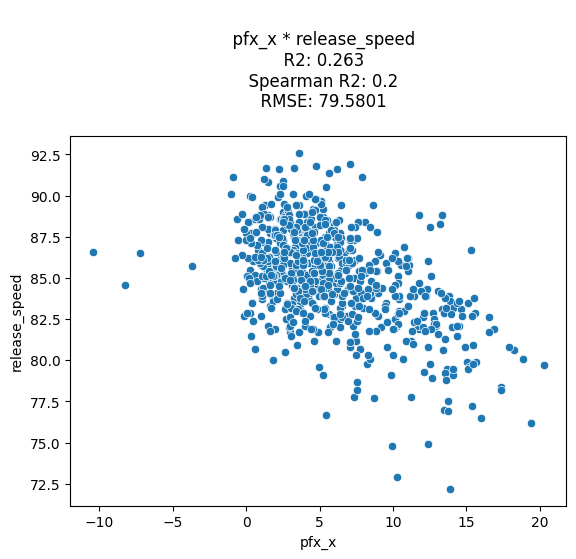

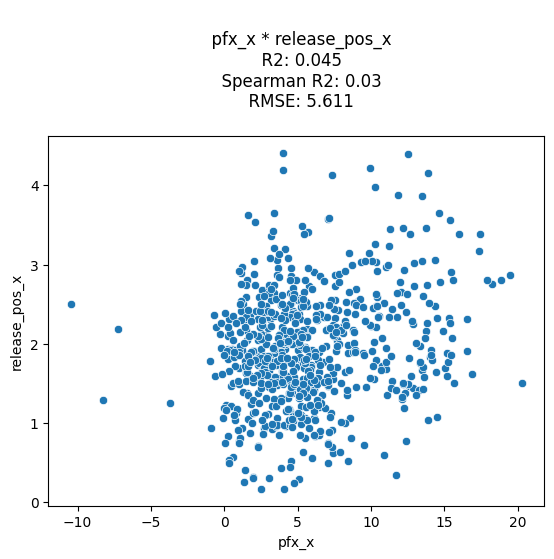

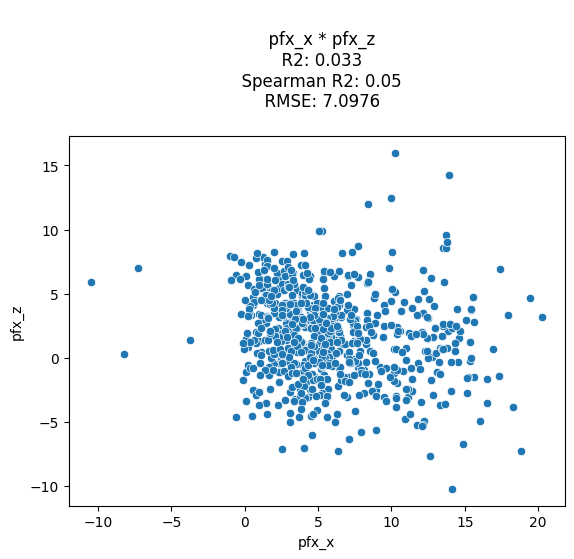

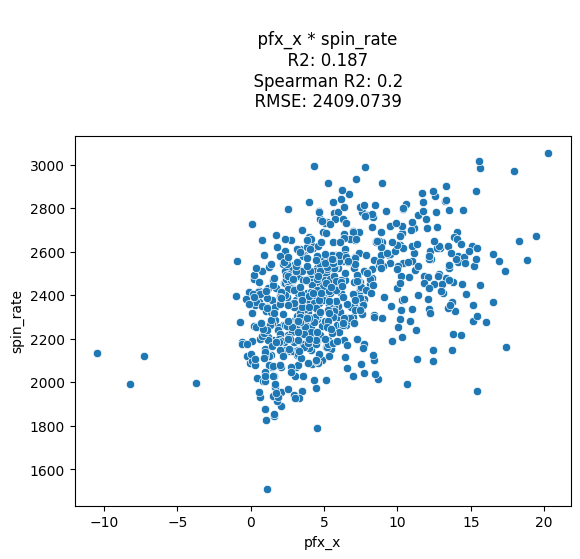

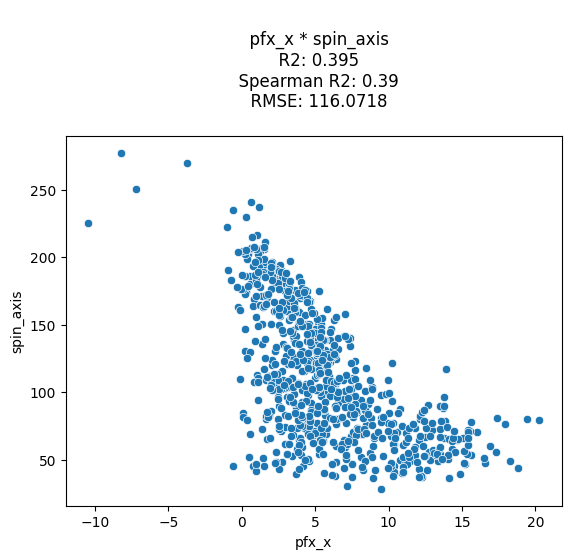

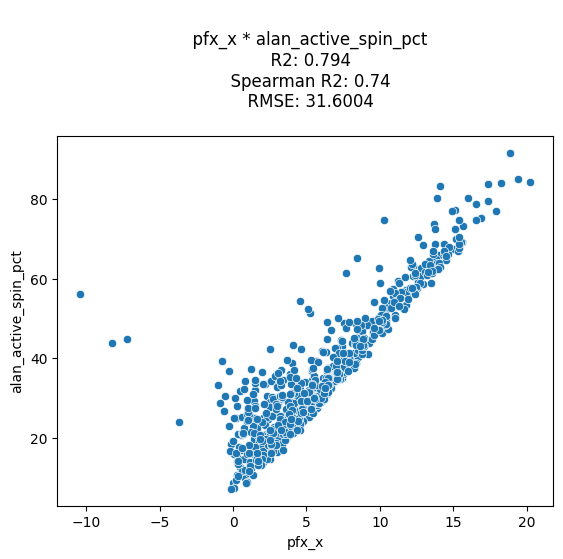

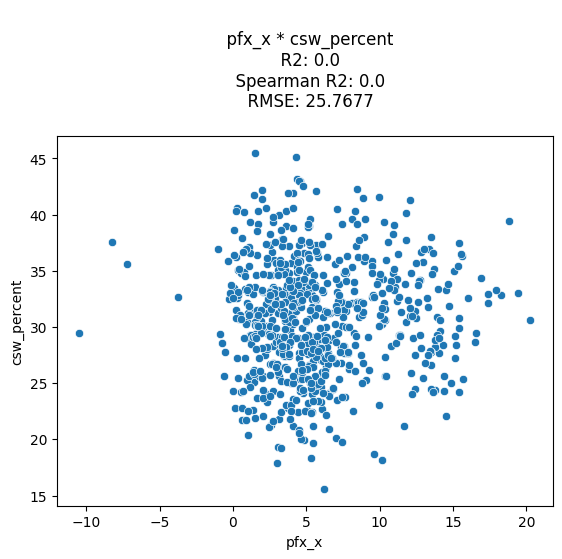

In [24]:
#exploring correlation between horizontal movement of sliders and other pitch variables
hoz_mov_inch = 'pfx_x'
features = ['release_speed', 'release_pos_x', 'pfx_z', 'spin_rate', 'spin_axis', 'alan_active_spin_pct', 'csw_percent']

for feature in features:
  sns.scatterplot(data=df_slider, x=hoz_mov_inch, y=feature)

  r2 = pearsonr(df_slider[hoz_mov_inch], df_slider[feature])[0]**2

  sr2 = spearmanr(df_slider[hoz_mov_inch], df_slider[feature])[0]**2

  rmse = mean_squared_error(df_slider[hoz_mov_inch], df_slider[feature])**0.5

  title_str = f"""
  {hoz_mov_inch} * {feature}
  R2: {r2.round(3)}
  Spearman R2: {sr2.round(2)}
  RMSE: {rmse.round(4)}
  """

  plt.title(title_str)
  plt.show()

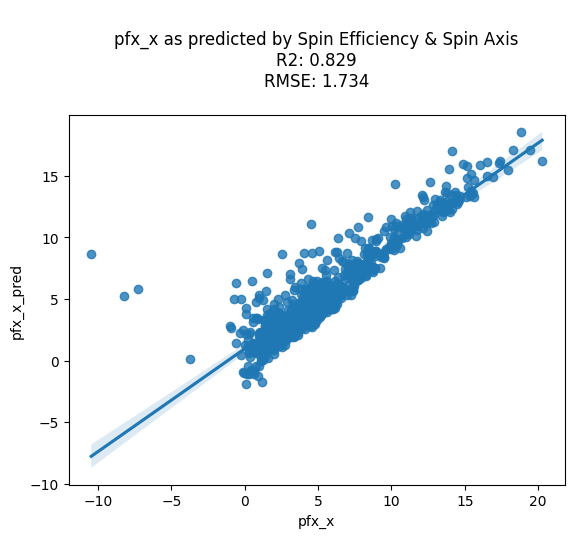

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.838    
Dependent Variable:  pfx_x             AIC:                 2743.7144
Date:                2023-11-07 23:36  BIC:                 2757.3890
No. Observations:    705               Log-Likelihood:      -1368.9  
Df Model:            2                 F-statistic:         1821.    
Df Residuals:        702               Prob (F-statistic):  1.46e-278
R-squared:           0.838             Scale:               2.8567   
---------------------------------------------------------------------
                      Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                 0.9919   0.2920   3.3970 0.0007  0.4186  1.5652
spin_axis            -0.0212   0.0015 -13.9380 0.0000 -0.0242 -0.0182
alan_active_spin_pct  0.2034   0.0046  43.8631 0.0000  0.1943  0.2125
---------------------------------------

In [22]:
target = 'pfx_x'
features = ['spin_axis', 'alan_active_spin_pct']

kf = KFold(5, shuffle=True, random_state=1)

#create out-of-sample pd.Series to save models
oos_preds = pd.Series(dtype=float)

for train_index, test_index in kf.split(df_slider):
  train = df_slider.loc[train_index]
  test = df_slider.loc[test_index]
  #creating the datasets from the 5 folds

  model = LinearRegression()
  model.fit(train.loc[:, features], train[target])
  test[f"{target}_pred"] = model.predict(test.loc[:, features])

  #concatenate new preds to oos series
  oos_preds = pd.concat([oos_preds, test[f"{target}_pred"]])

#join oos onto main dataframe
df_slider[f"{target}_pred"] = oos_preds

r2 = pearsonr(df_slider[target], df_slider[f"{target}_pred"])[0]**2
rmse = mean_squared_error(df_slider[target], df_slider[f"{target}_pred"])**0.5

title_str = f"""
pfx_x as predicted by Spin Efficiency & Spin Axis
R2: {r2.round(3)}
RMSE: {rmse.round(3)}
"""

sns.regplot(data=df_slider, x=target, y=f"{target}_pred")
plt.title(title_str)
plt.show()

##### to easily retrieve coefficients as printouts
import statsmodels.api as sm
X = df_slider[features]
X = sm.add_constant(X)  # Add a constant term to the predictor variables
y = df_slider[target]

model_sm = sm.OLS(y, X).fit()  # Fit the model using Ordinary Least Squares

# Get the summary of the model
print(model_sm.summary2())

In [25]:
#bucketing sliders using jenkspy package
#looking at 4 buckets -- slutter, traditional slider, gyro, and slurve
slider_axis_buckets = jenkspy.jenks_breaks(df_slider['spin_axis'], n_classes=4)
slider_axis_buckets = np.round(slider_axis_buckets, 2)
slider_axis_buckets = slider_axis_buckets.tolist()

slider_spin_eff_buckets = jenkspy.jenks_breaks(df_slider['alan_active_spin_pct'], n_classes=4)

slider_pfx_x_buckets = jenkspy.jenks_breaks(df_slider['pfx_x'], n_classes=4)
slider_pfx_x_buckets = np.round(slider_pfx_x_buckets, 2)
slider_pfx_x_buckets = slider_pfx_x_buckets.tolist()

slider_mph_buckets = jenkspy.jenks_breaks(df_slider['release_speed'], n_classes=4)

print(f"""
Axis Buckets
{slider_axis_buckets}

Spin Eff. Buckets
{slider_spin_eff_buckets}

Hoz. Mov. Buckets
{slider_pfx_x_buckets}

Velo Buckets
{slider_mph_buckets}
""")


Axis Buckets
[28.37, 75.79, 114.16, 161.34, 277.23]

Spin Eff. Buckets
[7.26, 24.65, 37.89, 55.53, 91.56]

Hoz. Mov. Buckets
[-10.46, 3.1, 6.7, 11.23, 20.27]

Velo Buckets
[72.2, 81.0, 84.4, 87.1, 92.6]



In [26]:
#identifying gyro sliders based on community-established definition
df_gyro = df_slider.loc[(df_slider['spin_axis']>=120) & (df_slider['alan_active_spin_pct']<28)].reset_index(drop=True)
df_gyro['pitch_type'] = 'GY'

#removing the now-labeled gyros from the slider dataset
df_slider.loc[(df_slider['spin_axis']>=120) & (df_slider['alan_active_spin_pct']<28), 'pitch_type'] = 'GY'
df_slider = df_slider.loc[(df_slider['pitch_type'] == 'SL')]

In [27]:
df_gyro.loc[df_gyro['release_speed']<84]

,year,player_name,pitch_type,pitch_hand,pitches,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,spin_rate,spin_axis,alan_active_spin_pct,run_value_per_100,csw_percent,woba,est_woba,pfx_x_pred
22,2022,"Ryan, Joe",GY,R,405,82.3,2.391151,5.048513,3.216115,2.953094,2134,153.131894,21.52,-2.1,28.4,0.361,0.275,2.060515
28,2022,"Cueto, Johnny",GY,R,390,83.5,2.674505,5.604609,2.748438,5.430937,2235,189.453125,27.69,0.4,33.6,0.298,0.294,2.522161
31,2022,"Lee, Dylan",GY,L,360,83.8,1.725810,6.406229,3.243687,4.374637,2080,167.762570,24.73,1.9,38.6,0.245,0.257,2.456127
35,2022,"Manaea, Sean",GY,L,314,81.7,3.053121,5.361656,3.572102,2.352229,2030,138.388535,25.75,-0.5,27.4,0.309,0.252,3.250765
37,2022,"Herget, Jimmy",GY,R,339,83.2,2.344340,5.011026,3.376188,4.301349,2612,155.731563,23.13,2.7,37.2,0.183,0.268,2.334284
39,2022,"Chafin, Andrew",GY,L,287,82.9,1.928611,6.185799,0.242083,-0.592500,2492,130.274306,14.07,1.6,36.2,0.162,0.175,1.020737
52,2022,"Falter, Bailey",GY,L,192,83.5,0.973220,5.708878,4.471024,3.612293,1976,137.686275,26.64,0.1,32.8,0.346,0.346,3.435454
62,2022,"Pineda, Michael",GY,R,157,80.7,2.349427,6.478599,0.600764,1.355159,1933,206.184713,11.74,0.5,21.7,0.210,0.219,-1.079447
73,2022,"Castillo, Max",GY,R,131,83.4,3.079291,5.895816,3.097021,3.375319,2377,132.581560,23.47,-1.5,26.0,0.332,0.370,2.931247
107,2023,"Manaea, Sean",GY,L,305,83.7,2.739639,5.691082,2.069902,2.211934,2068,123.584718,16.84,-2.8,25.6,0.413,0.340,1.830281


In [28]:
#merging sliders into one dataframe for comparison
df_diff_sliders = pd.concat([df_slider, df_gyro, df_sweeper], axis=0)

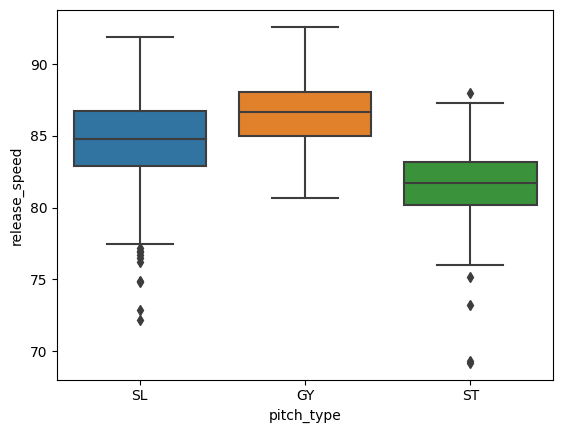

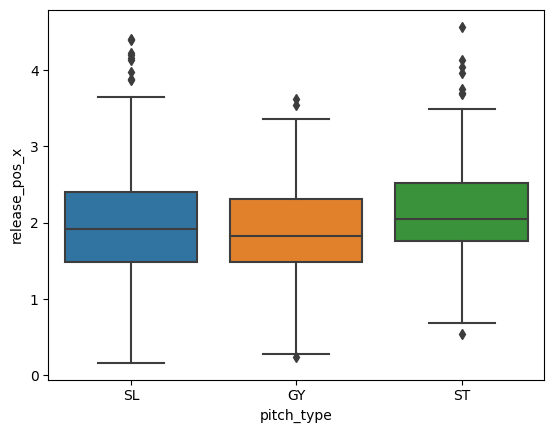

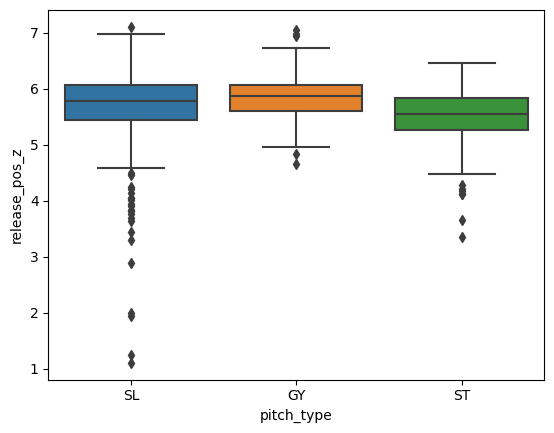

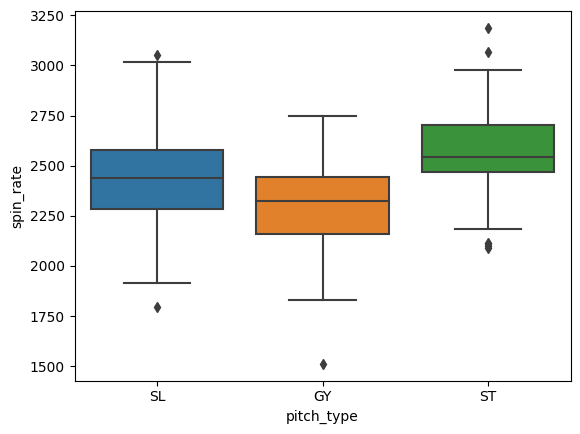

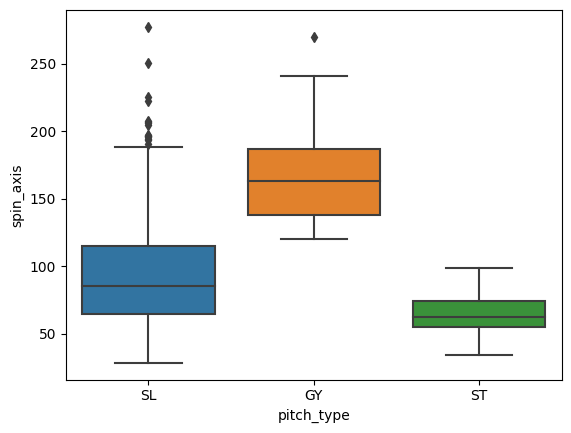

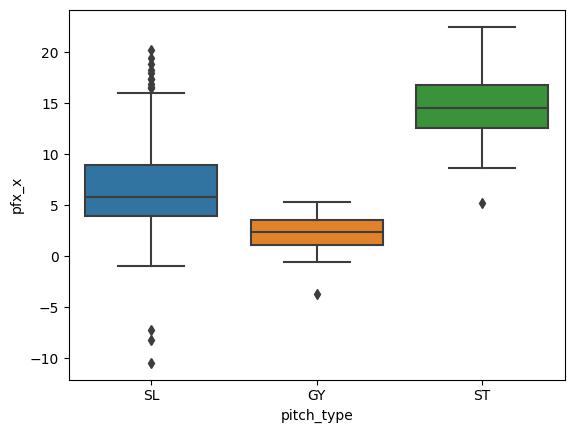

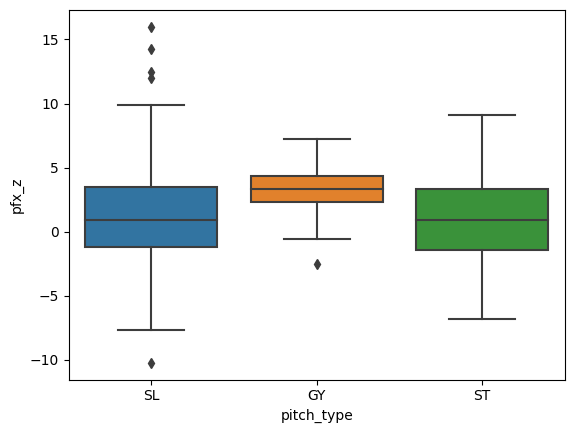

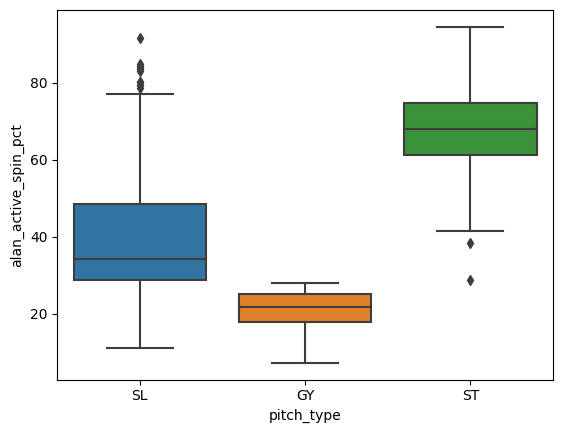

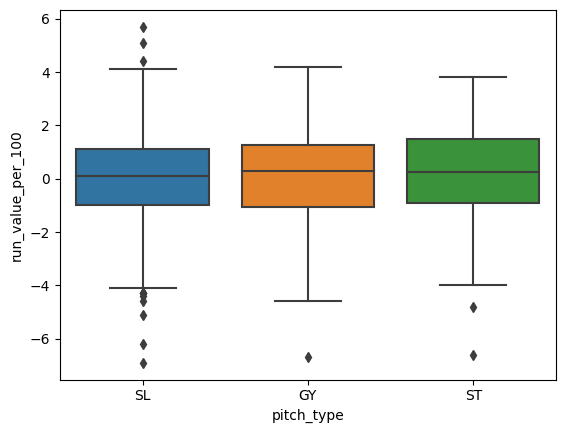

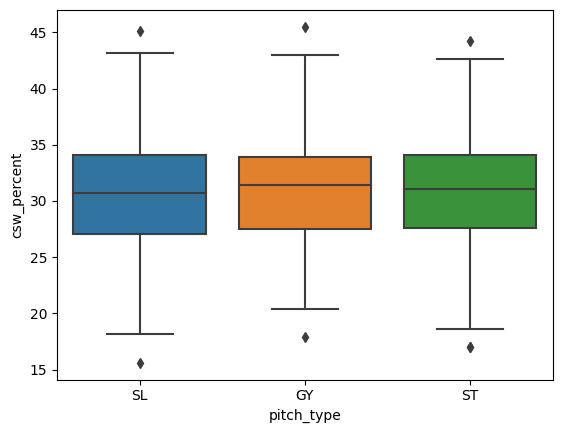

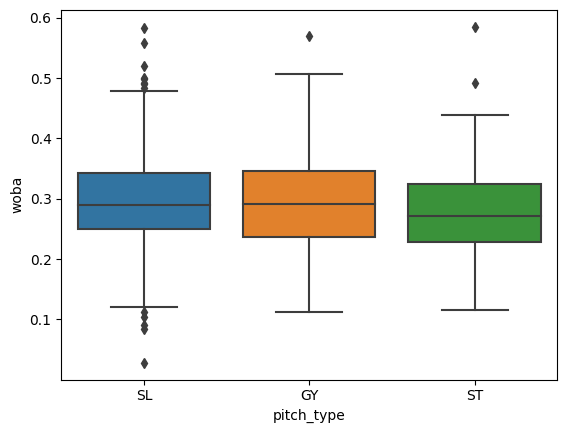

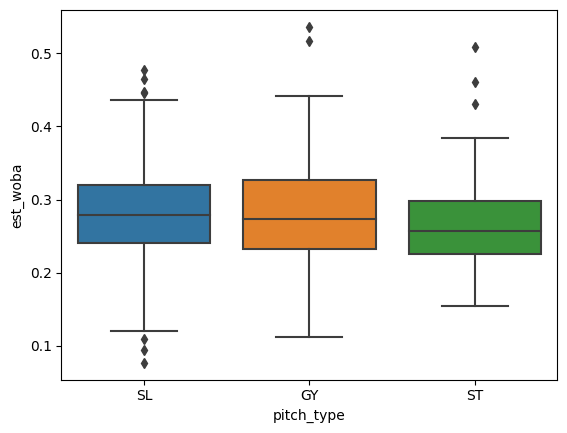

In [29]:
features = ['release_speed', 'release_pos_x', 'release_pos_z', 'spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'alan_active_spin_pct', 'run_value_per_100', 'csw_percent', 'woba', 'est_woba']

for feature in features:
  sns.boxplot(data=df_diff_sliders, x='pitch_type', y=feature)
  plt.show()

Takeaways:

*  Pitchers who throw gyros tend to have higher arm slots closer to the body
*  gyros typically have lower spin rates
*  gyros rise, perhaps mimicking rising fastballs
*  highest 50th percentile CSW% when compared to sweepers or other sliders as a whole
*  sweepers perform best according to wOBA and xwOBA

In [39]:
df_slider.describe()

,year,pitches,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,spin_rate,spin_axis,alan_active_spin_pct,run_value_per_100,csw_percent,woba,est_woba,pfx_x_pred
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,2022.499093,323.052632,84.671688,1.958266,5.687138,6.722962,1.284674,2434.580762,94.792331,38.796552,-0.028131,30.566969,0.295799,0.281525,6.883588
std,0.500454,210.844870,2.960865,0.720340,0.655044,4.198176,3.612956,218.896348,41.124137,15.635326,1.708532,4.974436,0.076795,0.064195,3.577648
min,2022.000000,100.000000,72.200000,0.165786,1.107599,-10.461714,-10.222430,1792.000000,28.368715,11.160000,-6.900000,15.600000,0.028000,0.077000,0.700828
25%,2022.000000,161.500000,82.900000,1.487131,5.444767,3.985165,-1.187380,2283.000000,64.866420,28.735000,-1.000000,27.100000,0.250500,0.240000,4.214434
50%,2022.000000,267.000000,84.800000,1.919912,5.783613,5.816216,0.955596,2437.000000,85.250000,34.280000,0.100000,30.700000,0.290000,0.279000,5.707639
75%,2023.000000,426.000000,86.700000,2.397339,6.067044,8.979276,3.524053,2577.000000,114.599567,48.505000,1.100000,34.050000,0.342000,0.320000,9.156165
max,2023.000000,1338.000000,91.900000,4.411897,7.106357,20.269880,15.990968,3054.000000,277.228395,91.560000,5.700000,45.100000,0.583000,0.477000,18.567695


In [40]:
df_gyro.describe()

,year,pitches,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,spin_rate,spin_axis,alan_active_spin_pct,run_value_per_100,csw_percent,woba,est_woba,pfx_x_pred
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,2022.500000,349.948052,86.609091,1.830772,5.863341,2.303361,3.370944,2296.805195,164.305677,20.873247,0.079221,31.140909,0.293474,0.280331,1.762780
std,0.501631,221.979561,2.127085,0.676658,0.412156,1.544389,1.585832,213.792339,29.891665,5.135072,1.801875,5.308196,0.079201,0.067671,1.239289
min,2022.000000,102.000000,80.700000,0.235599,4.653178,-3.718367,-2.503939,1511.000000,120.051852,7.260000,-6.700000,17.900000,0.113000,0.112000,-1.931894
25%,2022.000000,167.750000,85.025000,1.491110,5.600191,1.086492,2.313858,2160.000000,138.104535,17.735000,-1.075000,27.525000,0.237000,0.232250,1.099989
50%,2022.500000,292.000000,86.650000,1.827100,5.864335,2.326000,3.350178,2322.000000,163.251435,21.640000,0.300000,31.400000,0.290500,0.273500,2.016443
75%,2023.000000,463.000000,88.075000,2.308244,6.075181,3.521797,4.365342,2444.000000,186.347834,25.015000,1.275000,33.925000,0.345250,0.326500,2.585568
max,2023.000000,1095.000000,92.600000,3.623773,7.052525,5.357009,7.230993,2748.000000,269.756944,27.990000,4.200000,45.500000,0.569000,0.536000,3.834181


In [41]:
df_sweeper.describe()

,pitches,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,spin_rate,spin_axis,alan_active_spin_pct,run_value_per_100,csw_percent,woba,est_woba
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,308.500000,81.571053,2.141451,5.475992,14.557609,1.058952,2572.203947,64.293059,67.593224,0.234868,30.753947,0.276566,0.264309
std,175.339595,2.837139,0.714886,0.518616,2.905266,3.202448,198.442623,13.433868,11.507549,1.788012,5.040799,0.073866,0.057642
min,100.000000,69.200000,0.541094,3.353866,5.201618,-6.774400,2091.000000,34.016886,28.830000,-6.600000,17.000000,0.115000,0.154000
25%,166.250000,80.200000,1.756111,5.266654,12.570784,-1.442472,2466.750000,54.683676,61.372500,-0.900000,27.600000,0.227500,0.226000
50%,252.000000,81.700000,2.050807,5.553352,14.487128,0.878053,2541.000000,62.621419,68.040000,0.250000,31.050000,0.270500,0.256500
75%,425.250000,83.200000,2.517570,5.840178,16.772859,3.300226,2700.500000,74.355985,74.672500,1.500000,34.050000,0.324250,0.298500
max,983.000000,88.000000,4.565966,6.465191,22.500276,9.137838,3188.000000,98.652582,94.590000,3.800000,44.200000,0.585000,0.508000


#Examining Arsenals of Gyro Slider Pitchers

In [30]:
#adding gyros to the overall dataset

df.reset_index(inplace=True, drop=True)

#normalizing spin axis to RHP
df['spin_axis_normalized'] = df['spin_axis']

df.loc[
    (df['pitch_hand'] == 'L'),
    'spin_axis_normalized'] = (360-df['spin_axis'])

#normalizing pfx_x to RHP
df['pfx_x_normalized'] = df['pfx_x']

df.loc[
    (df['pitch_hand'] == 'L'),
    'pfx_x_normalized'] = df['pfx_x'].abs()

df.loc[
    (df['pitch_type'] == 'SL') &
    (df['spin_axis_normalized']>=120) &
    (df['alan_active_spin_pct']<28),
    'pitch_type'] = 'GY'

In [31]:
#creating a list of pitchers with gyro sliders in their arsenals
gyro_pitchers = df.loc[
    (df['pitch_type'] == 'GY'),
    'player_name'
]

gyro_pitchers = gyro_pitchers.unique()
#there are more names in this list than in df_gyro due to requirement of 100 pitches when creating df_slider

df_gyro_arsenal = df.loc[(df['player_name'].isin(gyro_pitchers))]

In [44]:
#identifying highest performing pitchers with gyros in their arsenals

__df = df_gyro_arsenal.loc[: , ['player_name', 'year', 'run_value']].groupby(['player_name', 'year'], as_index=False).sum()
__df.sort_values(by='run_value', ascending=False).head(20)

#75% percentile of RV is 5 total runs
best_gyro_pitchers = __df.loc[__df['run_value'] >= 5.0].sort_values(by='run_value', ascending=False)

In [ ]:
best_gyro_pitchers.head()

In [33]:
#identifying each pitch in the arsenal of the best gyro pitchers
best_gyro_pitchers_arsenal = pd.merge(best_gyro_pitchers, df_gyro_arsenal, on=['player_name', 'year'], how='inner')

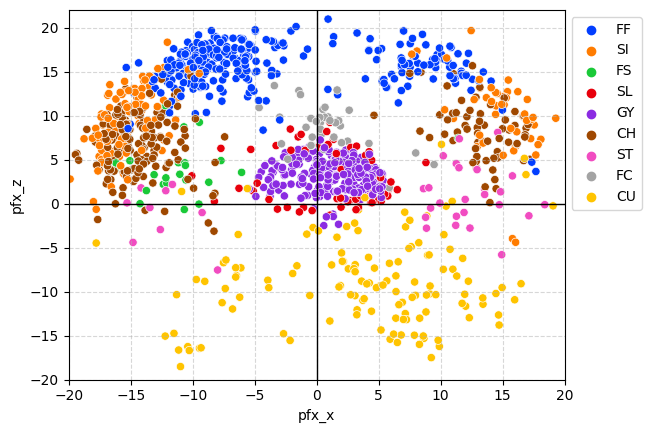

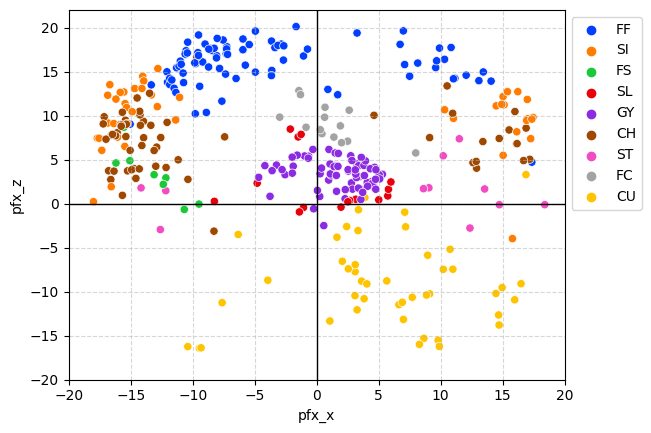

In [46]:
#graphing arsenals of best gyro pitchers
datasets = [df_gyro_arsenal, best_gyro_pitchers_arsenal]

custom_palette = sns.color_palette("bright", n_colors=len(df_gyro_arsenal['pitch_type'].unique()))

for dataset in datasets:

  sns.scatterplot(data=dataset, x='pfx_x', y='pfx_z', hue='pitch_type', palette=custom_palette, hue_order=df_gyro_arsenal['pitch_type'].unique())
  plt.xlim(-20, 20)
  plt.ylim(-20, 22)
  plt.axhline(0, color='black', linewidth=1)
  plt.axvline(0, color='black', linewidth=1)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()

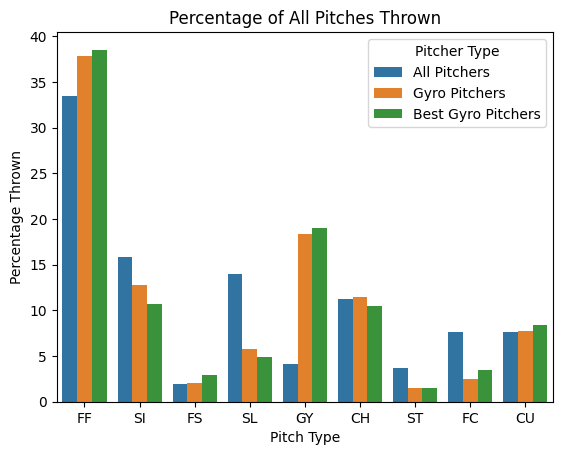

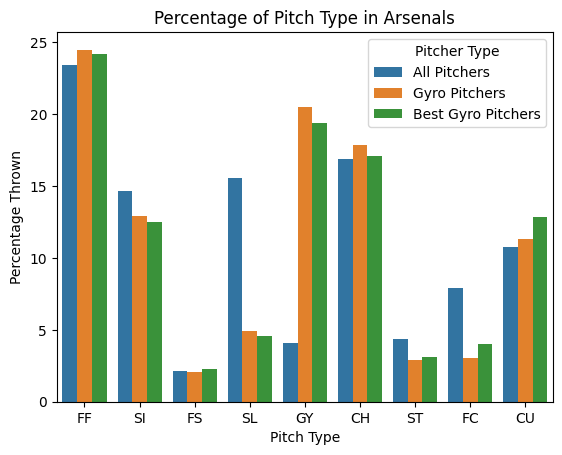

In [54]:
#examining proportion of pitch types amongst gyro slider pitchers
pitches = df_gyro_arsenal['pitch_type'].unique()

#create out-of-sample pd.Dataframe to save results
oos_results_pitches = pd.DataFrame()
oos_results_arsenal = pd.DataFrame()

for pitch in pitches:
  pct_in_all_pitches = (df.loc[df['pitch_type'] == pitch, 'pitches'].sum() / (df['pitches'].sum()) * 100)

  pct_in_gyro_pitches = (df_gyro_arsenal.loc[df_gyro_arsenal['pitch_type'] == pitch, 'pitches'].sum() / (df_gyro_arsenal['pitches'].sum()) * 100)

  pct_in_best_gyro_pitches = (best_gyro_pitchers_arsenal.loc[best_gyro_pitchers_arsenal['pitch_type'] == pitch,'pitches'].sum() / (best_gyro_pitchers_arsenal['pitches'].sum()) * 100)

  data_pitches = {'All Pitchers': pct_in_all_pitches,
          'Gyro Pitchers': pct_in_gyro_pitches,
          'Best Gyro Pitchers': pct_in_best_gyro_pitches
          }

  temp_df_pitches = pd.DataFrame(data_pitches, index=[pitch])

  oos_results_pitches = pd.concat([oos_results_pitches, temp_df_pitches])

  pct_in_all_arsenal = (len(df.loc[df['pitch_type'] == pitch].index)/len(df.index))*100

  pct_in_gyro_arsenal = (len(df_gyro_arsenal.loc[df_gyro_arsenal['pitch_type'] == pitch].index)/len(df_gyro_arsenal.index))*100

  pct_in_best_gyro_arsenal = (len(best_gyro_pitchers_arsenal.loc[best_gyro_pitchers_arsenal['pitch_type'] == pitch].index)/len(best_gyro_pitchers_arsenal.index))*100

  data_arsenal = {'All Pitchers': pct_in_all_arsenal,
          'Gyro Pitchers': pct_in_gyro_arsenal,
          'Best Gyro Pitchers': pct_in_best_gyro_arsenal}

  temp_df_arsenal = pd.DataFrame(data_arsenal, index=[pitch])

  oos_results_arsenal = pd.concat([oos_results_arsenal, temp_df_arsenal])

# Reset index to make 'pitch_type' a column
oos_results_pitches = oos_results_pitches.reset_index()
oos_results_arsenal = oos_results_arsenal.reset_index()

# Melt the DataFrames for easier plotting
oos_results_melted_pitches = pd.melt(oos_results_pitches, id_vars=['index'], var_name='Pitcher Type', value_name='Percentage')
oos_results_melted_arsenal = pd.melt(oos_results_arsenal, id_vars=['index'], var_name='Pitcher Type', value_name='Percentage')

xlabel_str = 'Pitch Type'
ylabel_str = 'Percentage Thrown'
legend_str = 'Pitcher Type'

sns.barplot(data=oos_results_melted_pitches, x='index', y='Percentage', hue='Pitcher Type')
plt.xlabel(xlabel_str)
plt.ylabel(ylabel_str)
plt.legend(title=legend_str)
plt.title("Percentage of All Pitches Thrown")
plt.show()

sns.barplot(data=oos_results_melted_arsenal, x='index', y='Percentage', hue='Pitcher Type')
plt.xlabel(xlabel_str)
plt.ylabel(ylabel_str)
plt.legend(title=legend_str)
plt.title("Percentage of Pitch Type in Arsenals")
plt.show()

Takeaways:

*  lots of fastballs & curveballs suggest a north-south pitching style
*  fewer sinkers amongst best gyro pitchers
*  changeups remain popular as an option that provides a different velo look
*  far fewer sweepers and cutters mean less emphasis on horizontal movement

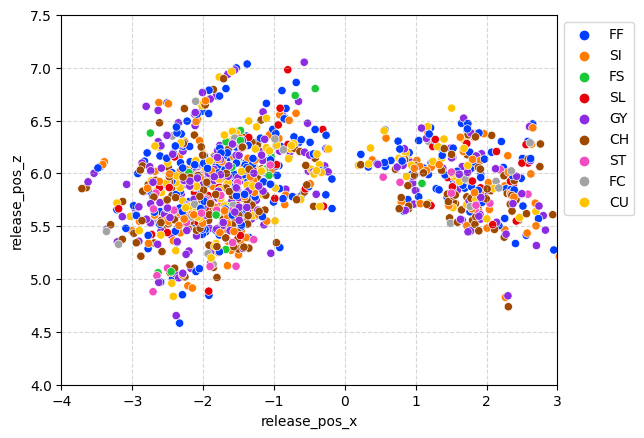

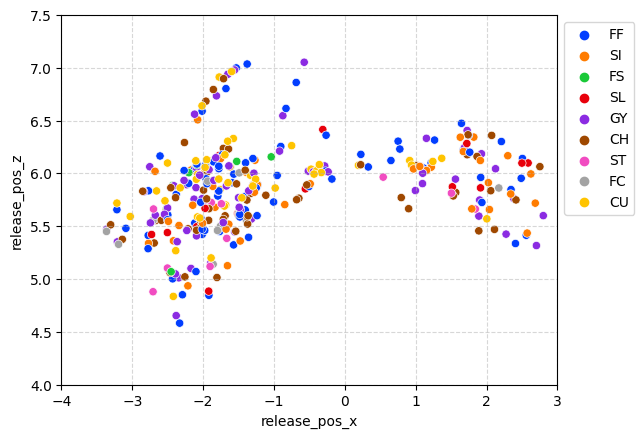

In [55]:
#examining release point data
datasets = [df_gyro_arsenal, best_gyro_pitchers_arsenal]

for dataset in datasets:
  sns.scatterplot(data=dataset, x='release_pos_x', y='release_pos_z', hue='pitch_type', palette=custom_palette, hue_order=df_gyro_arsenal['pitch_type'].unique())
  plt.xlim(-4, 3)
  plt.ylim(4, 7.5)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()